# run with min_child_weight = 1 and grad,hess multiplied by n

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit
from tqdm import tqdm
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
seed = 0

In [23]:
X, Y = data.load_german()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_train = X_train.Sex.values
A_test = X_test.Sex.values
X_train.insert(0, 'sensitive', A_train) # add sensitive attribute as first column
X_test.insert(0, 'sensitive', A_test)

In [24]:
param_space = {
    "min_child_weight" : FloatDistribution(0.01, 10, log = True),
    "n_estimators" : IntDistribution(5, 50, step=3),
    "eta" : FloatDistribution(0.01, 0.5),
    "max_leaves" : IntDistribution(2, 50), 
    "colsample_bytree" : FloatDistribution(0.1, 1),
    "max_depth" : IntDistribution(3, 10),
    "l2_weight" : FloatDistribution(0.01, 100),
}

## Model without fairness

Performing a search with Optuna, it will perform a 5-fold cross validation and select the parameters with the best mean score. The score used is the ROC.

In [25]:
model_search = OptunaSearchCV(
    models.XtremeFair(fair_weight=0),
    param_space,
    n_trials=100,
    random_state = seed,
    cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = seed), # remove this line to run 5-fold
    verbose = 0,
)
model_search.fit(X_train, Y_train);

/tmp/ipykernel_18836/2182069732.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search = OptunaSearchCV(
[I 2023-11-14 16:50:38,523] A new study created in memory with name: no-name-c61262fa-c72e-4fa0-b19e-79d29455f812


[I 2023-11-14 16:50:39,121] Trial 0 finished with value: 0.7375 and parameters: {'min_child_weight': 0.2871719181692574, 'n_estimators': 35, 'eta': 0.4929322648241834, 'max_leaves': 11, 'colsample_bytree': 0.6250705061352616, 'max_depth': 10, 'l2_weight': 18.056224936021376}. Best is trial 0 with value: 0.7375.
[I 2023-11-14 16:50:39,782] Trial 1 finished with value: 0.75625 and parameters: {'min_child_weight': 1.271762178744101, 'n_estimators': 44, 'eta': 0.4003875546741267, 'max_leaves': 44, 'colsample_bytree': 0.5657519456923042, 'max_depth': 3, 'l2_weight': 29.66572559129418}. Best is trial 1 with value: 0.75625.
[I 2023-11-14 16:50:39,834] Trial 2 finished with value: 0.73125 and parameters: {'min_child_weight': 0.026680766551796777, 'n_estimators': 8, 'eta': 0.4348911610307821, 'max_leaves': 34, 'colsample_bytree': 0.42152928551669056, 'max_depth': 10, 'l2_weight': 16.519839536171137}. Best is trial 1 with value: 0.75625.
[I 2023-11-14 16:50:40,002] Trial 3 finished with value: 0

In [26]:
utils.eval_model_train_test(
    model_search,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
    p = 0.5,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.891073,0.955446,0.044554,0.395300,0.5,0.838078,0.840959,train_g0
1,0.887910,0.954545,0.045455,0.439592,0.5,0.827731,0.812155,train_g1
2,0.736204,0.873684,0.126316,0.504251,0.5,0.750000,0.805825,test_g0
3,0.747234,0.914894,0.085106,0.556356,0.5,0.722222,0.728814,test_g1


In [27]:
best_params = model_search.best_params_
best_params

{'min_child_weight': 2.8179641228705448,
 'n_estimators': 29,
 'eta': 0.46278950297763904,
 'max_leaves': 22,
 'colsample_bytree': 0.430460948558557,
 'max_depth': 6,
 'l2_weight': 37.01649253568421}

## Model with dual step

In [28]:
lambda_values = np.append([0],np.logspace(-2, 2, 20))

### Experiment 1

- Train model with fairness weight equal to $1$, and optimize the other parameters to maximize ROC. **Important**: parameter min child weight is fixed to $0$ to not interact with fairness weight.
- With best parameters found, train with different fairness weights to identify the impact.

In [29]:
model_search_fair = OptunaSearchCV(
    models.XtremeFair(fair_weight=1),
    param_space,
    n_trials=100,
    random_state = seed,
    cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = seed), # remove this line to run 5-fold,
    verbose = 0,
)
model_search_fair.fit(X_train, Y_train);

/tmp/ipykernel_18836/2743451004.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search_fair = OptunaSearchCV(
[I 2023-11-14 16:51:12,780] A new study created in memory with name: no-name-23a9e00f-5194-44a3-95e5-3e9b01166045


[I 2023-11-14 16:51:13,371] Trial 0 finished with value: 0.725 and parameters: {'min_child_weight': 0.2871719181692574, 'n_estimators': 35, 'eta': 0.4929322648241834, 'max_leaves': 11, 'colsample_bytree': 0.6250705061352616, 'max_depth': 10, 'l2_weight': 18.056224936021376}. Best is trial 0 with value: 0.725.
[I 2023-11-14 16:51:15,375] Trial 1 finished with value: 0.75 and parameters: {'min_child_weight': 1.271762178744101, 'n_estimators': 44, 'eta': 0.4003875546741267, 'max_leaves': 44, 'colsample_bytree': 0.5657519456923042, 'max_depth': 3, 'l2_weight': 29.66572559129418}. Best is trial 1 with value: 0.75.
[I 2023-11-14 16:51:15,726] Trial 2 finished with value: 0.7375 and parameters: {'min_child_weight': 0.026680766551796777, 'n_estimators': 8, 'eta': 0.4348911610307821, 'max_leaves': 34, 'colsample_bytree': 0.42152928551669056, 'max_depth': 10, 'l2_weight': 16.519839536171137}. Best is trial 1 with value: 0.75.
[I 2023-11-14 16:51:16,739] Trial 3 finished with value: 0.70625 and p

In [30]:
best_params_fair = model_search_fair.best_params_
best_params_fair

{'min_child_weight': 1.7088330237543305,
 'n_estimators': 44,
 'eta': 0.34522706465927677,
 'max_leaves': 33,
 'colsample_bytree': 0.44494655245668724,
 'max_depth': 4,
 'l2_weight': 40.00897023480406}

In [31]:
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XtremeFair(
        fair_weight=lambda_value,
        **best_params_fair
    )
    dual_model_.fit(X_train, Y_train)
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
        p = 0.5,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:04<00:00,  4.98it/s]


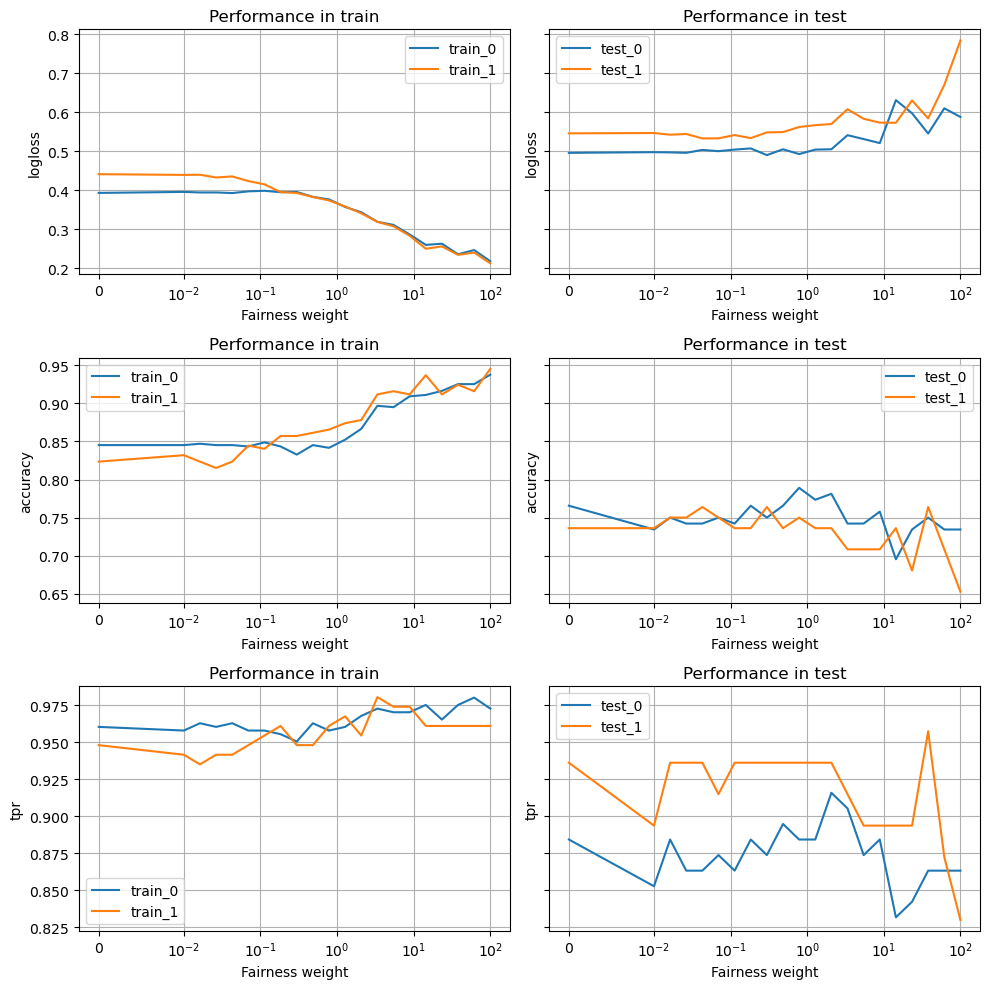

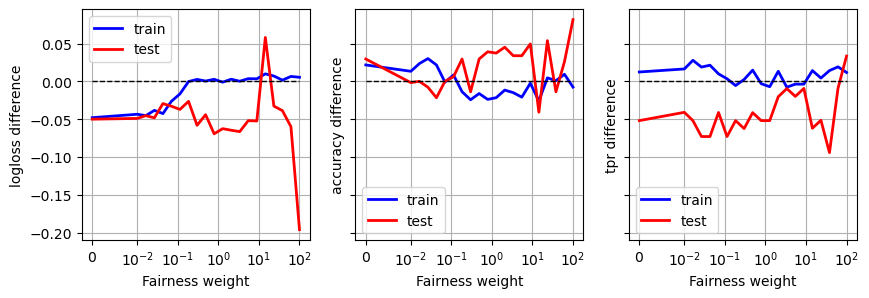

In [32]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 2

- Test different values of fairness weight, and for each, optimize the other parameters to maximize ROC.

In [33]:
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = OptunaSearchCV(
        models.XtremeFair(fair_weight=lambda_value,),
        param_space,
        n_trials=50,
        random_state = seed,
        cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = seed), # remove this line to run 5-fold
        verbose = 0,
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
        p = 0.5,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_18836/1117633236.py:3: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  dual_model_ = OptunaSearchCV(
[I 2023-11-14 16:52:35,622] A new study created in memory with name: no-name-06cfda45-1f0b-4cec-9a4e-ca9c61a7d681


[I 2023-11-14 16:52:35,934] Trial 0 finished with value: 0.7375 and parameters: {'min_child_weight': 0.2871719181692574, 'n_estimators': 35, 'eta': 0.4929322648241834, 'max_leaves': 11, 'colsample_bytree': 0.6250705061352616, 'max_depth': 10, 'l2_weight': 18.056224936021376}. Best is trial 0 with value: 0.7375.
[I 2023-11-14 16:52:36,035] Trial 1 finished with value: 0.75625 and parameters: {'min_child_weight': 1.271762178744101, 'n_estimators': 44, 'eta': 0.4003875546741267, 'max_leaves': 44, 'colsample_bytree': 0.5657519456923042, 'max_depth': 3, 'l2_weight': 29.66572559129418}. Best is trial 1 with value: 0.75625.
[I 2023-11-14 16:52:36,090] Trial 2 finished with value: 0.73125 and parameters: {'min_child_weight': 0.026680766551796777, 'n_estimators': 8, 'eta': 0.4348911610307821, 'max_leaves': 34, 'colsample_bytree': 0.42152928551669056, 'max_depth': 10, 'l2_weight': 16.519839536171137}. Best is trial 1 with value: 0.75625.
[I 2023-11-14 16:52:36,189] Trial 3 finished with value: 0

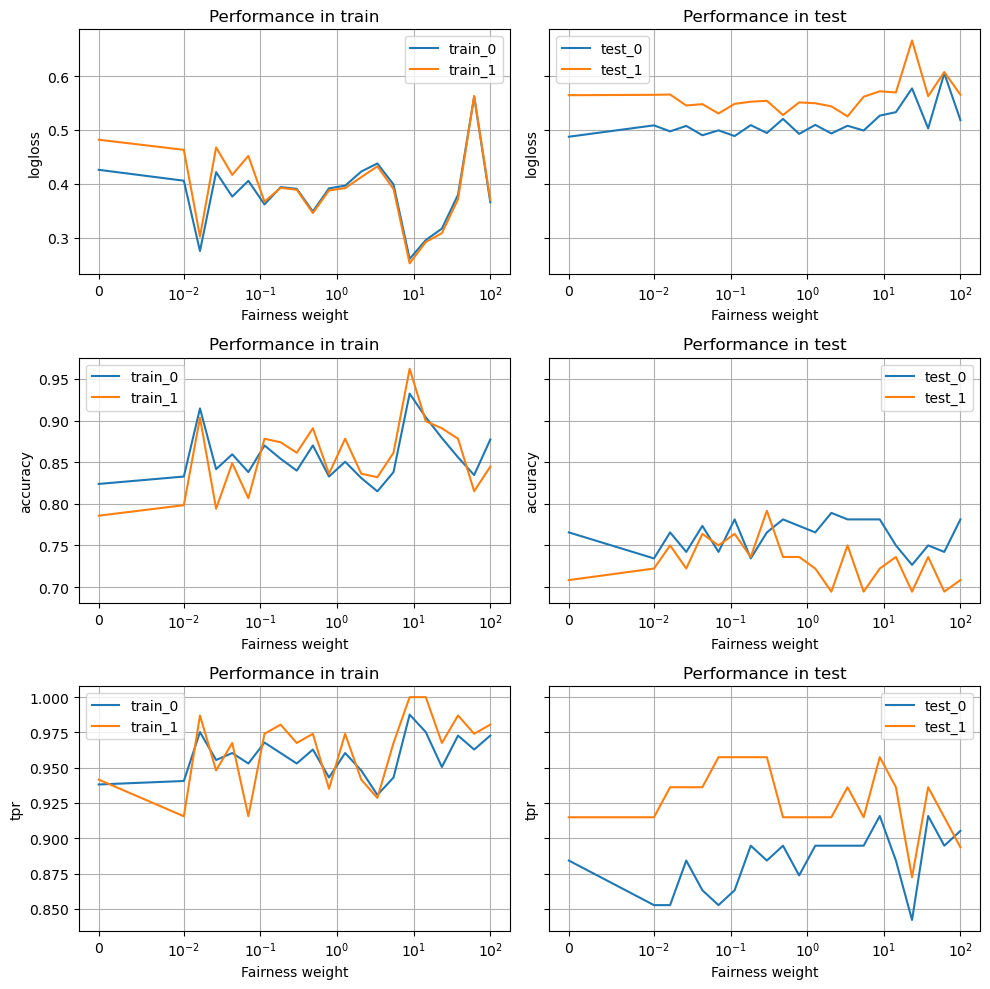

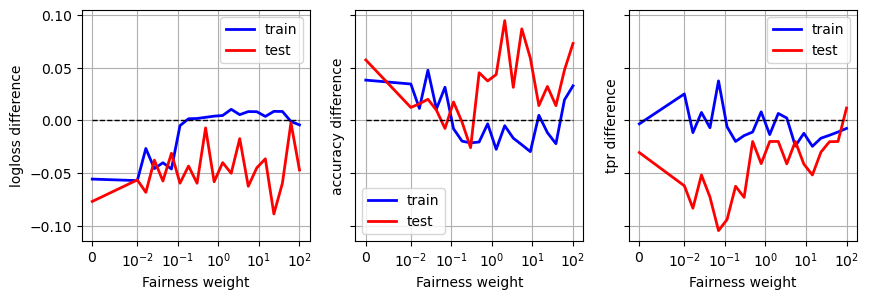

In [ ]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 3

- Train model with fairness weight equal to $1$, and optimize the other parameters to maximize an weighted sum of ROC and EOD. **Important**: parameter min child weight is fixed to $0$ to not interact with fairness weight.
- With best parameters found, train with different fairness weights to identify the impact.

In [ ]:
model_search_fair = OptunaSearchCV(
    models.XtremeFair(alpha = 0.5, fair_weight = 1,),
    param_space,
    n_trials=100,
    random_state = seed,
    cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = seed), # remove this line to run 5-fold
    verbose = 0,
)
model_search_fair.fit(X_train, Y_train);

/tmp/ipykernel_18836/3069391865.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search_fair = OptunaSearchCV(
[I 2023-11-14 16:32:19,816] A new study created in memory with name: no-name-a5c9b1f8-2fc4-4396-b3f4-560cd031886e


[I 2023-11-14 16:32:20,472] Trial 0 finished with value: 0.8375117695331575 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.8375117695331575.
[I 2023-11-14 16:32:20,735] Trial 1 finished with value: 0.8457077074050903 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 1 with value: 0.8457077074050903.
[I 2023-11-14 16:32:20,868] Trial 2 finished with value: 0.8459064471721648 and parameters: {'n_estimators': 5, 'eta': 0.1553275881561571, 'max_leaves': 8, 'colsample_bytree': 0.1704940423569844, 'max_depth': 9, 'l2_weight': 65.92778755735617}. Best is trial 2 with value: 0.8459064471721648.
[I 2023-11-14 16:32:21,203] Trial 3 finished with value: 0.8199594211578368 and parameters: {'n_estimators': 20, 'eta': 0

In [ ]:
best_params_fair = model_search_fair.best_params_
best_params_fair

{'n_estimators': 8,
 'eta': 0.03155555402197848,
 'max_leaves': 10,
 'colsample_bytree': 0.7693108240628376,
 'max_depth': 4,
 'l2_weight': 38.90517747085576}

In [ ]:
utils.eval_model_train_test(
    model_search_fair,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
    p = 0.5,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.774604,0.910891,0.089109,0.640615,0.5,0.774021,0.801743,train_g0
1,0.807243,0.941558,0.058442,0.647372,0.5,0.756303,0.747423,train_g1
2,0.749920,0.905263,0.094737,0.644421,0.5,0.750000,0.788991,test_g0
3,0.737872,0.936170,0.063830,0.652138,0.5,0.694444,0.698413,test_g1


In [ ]:
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XtremeFair(
        alpha=0.5,
        fair_weight = lambda_value,
        **best_params_fair
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
        p = 0.5,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)


100%|██████████| 21/21 [00:01<00:00, 19.44it/s]


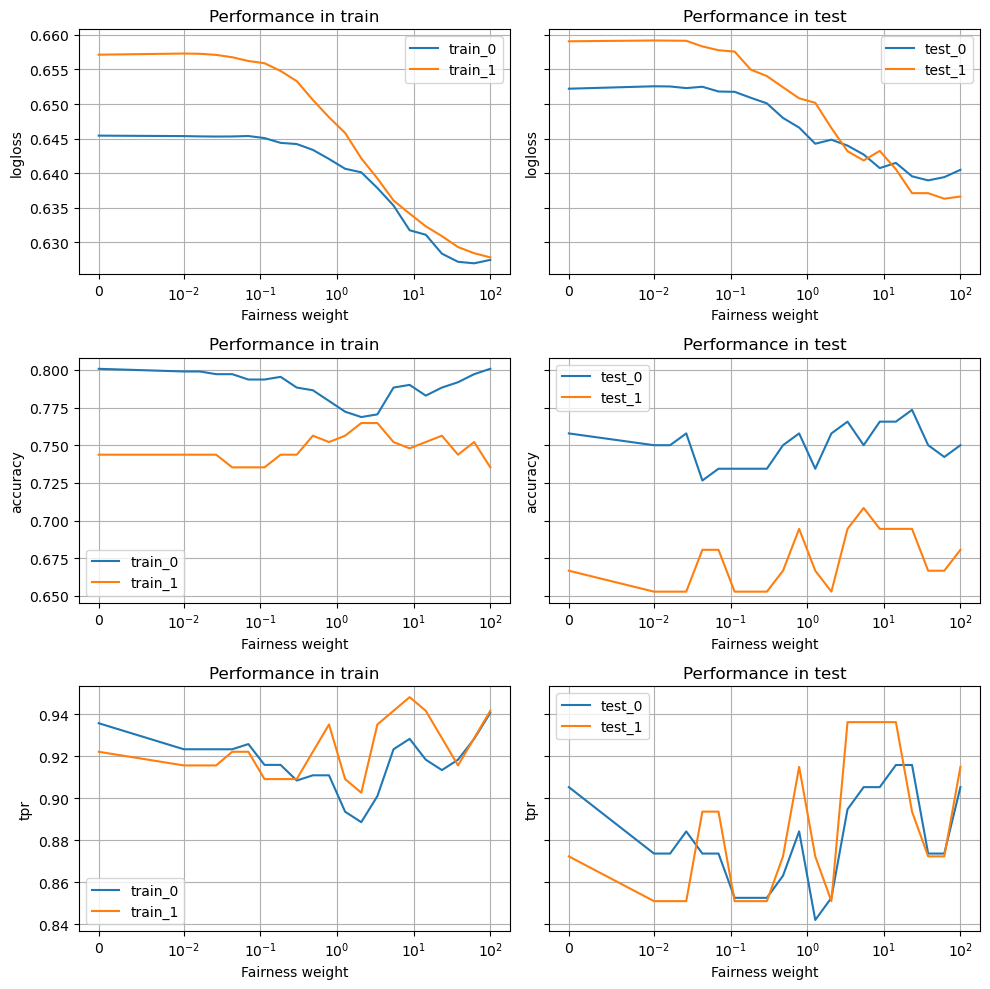

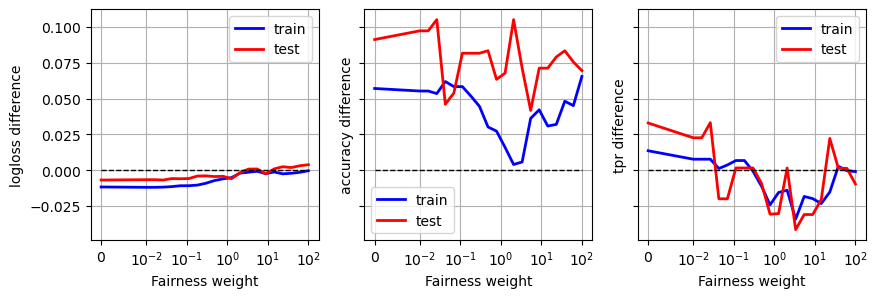

In [ ]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 4

In [ ]:
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = OptunaSearchCV(
        models.XtremeFair(alpha = 0.5, fair_weight = lambda_value,),
        param_space,
        n_trials=50,
        random_state = seed,
        cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = seed), # remove this line to run 5-fold
        verbose = 0,
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
        p = 0.5,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_18836/294578061.py:3: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  dual_model_ = OptunaSearchCV(
[I 2023-11-14 16:32:48,360] A new study created in memory with name: no-name-a74cf14f-0448-4a18-b63b-dd38ca60950a


[I 2023-11-14 16:32:48,806] Trial 0 finished with value: 0.8425494015216828 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.8425494015216828.
[I 2023-11-14 16:32:49,089] Trial 1 finished with value: 0.8486887681484223 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 1 with value: 0.8486887681484223.
[I 2023-11-14 16:32:49,187] Trial 2 finished with value: 0.8468982982635497 and parameters: {'n_estimators': 5, 'eta': 0.1553275881561571, 'max_leaves': 8, 'colsample_bytree': 0.1704940423569844, 'max_depth': 9, 'l2_weight': 65.92778755735617}. Best is trial 1 with value: 0.8486887681484223.
[I 2023-11-14 16:32:49,391] Trial 3 finished with value: 0.8331310558319093 and parameters: {'n_estimators': 20, 'eta': 0

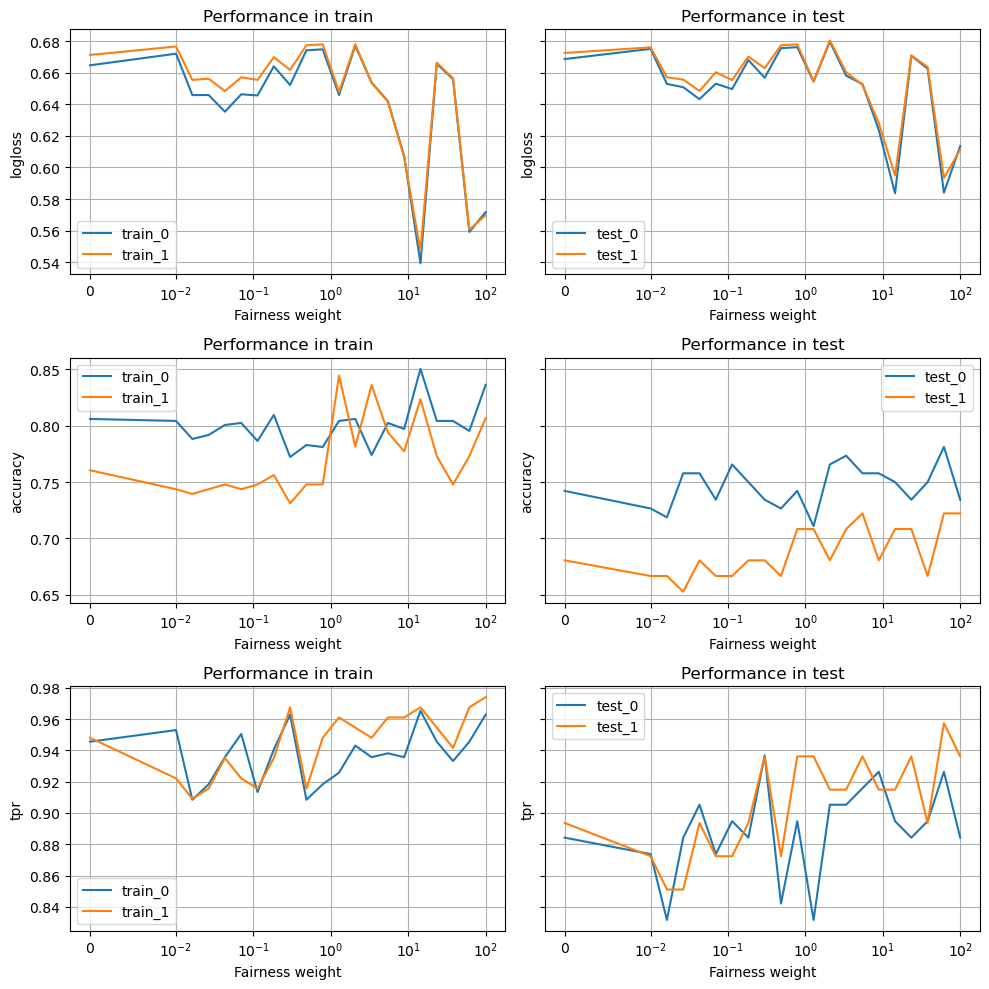

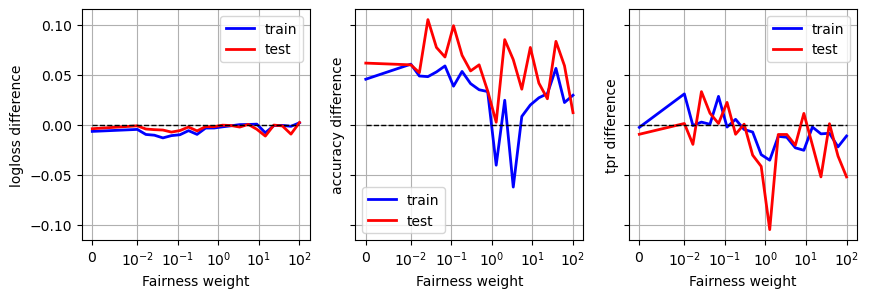

In [ ]:
utils.comparison_subgrous_metrics_lambda(results)